# GNNs with PyTorch Geometric
> Understanding the Fundamentals of Graph Neural and Graph Convolutional Networks with PyTorch Geometric

In [ ]:
# torch geometric
try: 
    import torch_geometric
except ModuleNotFoundError:
    # Installing torch geometric packages with specific CUDA+PyTorch version. 
    # See https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for details 
    import torch
    TORCH = torch.__version__.split('+')[0]
    CUDA = 'cu' + torch.version.cuda.replace('.','')

    !pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
    !pip install torch-geometric 
    import torch_geometric
import torch_geometric.nn as geom_nn
import torch_geometric.data as geom_data

## Graph attention networks (GAT)

### Code Practice

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

#### Structure

In [ ]:
class GATLayer(nn.Module):
    """
    Simple PyTorch Implementation of the Graph Attention layer.
    """
    def __init__(self):
        super(GATLayer, self).__init__()
      
    def forward(self, input, adj):
        print("")

Let's start from the forward method

#### Linear Transformation

$$
\bar{h'}_i = \textbf{W}\cdot \bar{h}_i
$$
with $\textbf{W}\in\mathbb R^{F'\times F}$ and $\bar{h}_i\in\mathbb R^{F}$.

$$
\bar{h'}_i \in \mathbb{R}^{F'}
$$

In [ ]:
in_features = 5
out_features = 2
nb_nodes = 3

W = nn.Parameter(torch.zeros(size=(in_features, out_features))) #xavier paramiter inizializator
nn.init.xavier_uniform_(W.data, gain=1.414)

input = torch.rand(nb_nodes,in_features) 


# linear transformation
h = torch.mm(input, W)
N = h.size()[0]

print(h.shape)

torch.Size([3, 2])


#### Attention Mechanism

In [ ]:
a = nn.Parameter(torch.zeros(size=(2*out_features, 1))) #xavier parameter inizializator
nn.init.xavier_uniform_(a.data, gain=1.414)
print(a.shape)

leakyrelu = nn.LeakyReLU(0.2)  # LeakyReLU

torch.Size([4, 1])


In [ ]:
a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * out_features)

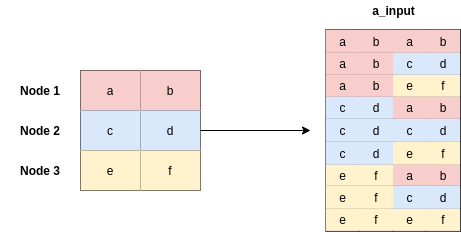

In [ ]:
e = leakyrelu(torch.matmul(a_input, a).squeeze(2))

In [ ]:
print(a_input.shape,a.shape)
print("")
print(torch.matmul(a_input,a).shape)
print("")
print(torch.matmul(a_input,a).squeeze(2).shape)

torch.Size([3, 3, 4]) torch.Size([4, 1])

torch.Size([3, 3, 1])

torch.Size([3, 3])


#### Masked Attention

In [ ]:
# Masked Attention
adj = torch.randint(2, (3, 3))

zero_vec  = -9e15*torch.ones_like(e)
print(zero_vec.shape)

torch.Size([3, 3])


In [ ]:
attention = torch.where(adj > 0, e, zero_vec)
print(adj,"\n",e,"\n",zero_vec)
attention

tensor([[0, 0, 1],
        [1, 1, 1],
        [1, 0, 1]]) 
 tensor([[-0.1585, -0.0303, -0.1897],
        [-0.1986, -0.0704, -0.2298],
        [-0.2208, -0.0925, -0.2519]], grad_fn=<LeakyReluBackward0>) 
 tensor([[-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15],
        [-9.0000e+15, -9.0000e+15, -9.0000e+15]])


tensor([[-9.0000e+15, -9.0000e+15, -1.8969e-01],
        [-1.9861e-01, -7.0399e-02, -2.2977e-01],
        [-2.2075e-01, -9.0000e+15, -2.5191e-01]], grad_fn=<SWhereBackward>)

In [ ]:
attention = F.softmax(attention, dim=1)
h_prime   = torch.matmul(attention, h)

In [ ]:
attention

tensor([[0.0000, 0.0000, 1.0000],
        [0.3219, 0.3660, 0.3121],
        [0.5078, 0.0000, 0.4922]], grad_fn=<SoftmaxBackward>)

In [ ]:
h_prime

tensor([[1.0922, 0.8739],
        [0.5854, 0.9056],
        [0.9083, 0.6195]], grad_fn=<MmBackward>)

h_prime vs h

In [ ]:
33print(h_prime,"\n",h)

tensor([[-0.3717, -0.7218],
        [-0.1823, -0.5417],
        [-0.2831, -0.6622]], grad_fn=<MmBackward>) 
 tensor([[-0.1524, -0.5741],
        [ 0.4143,  0.0255],
        [-0.3717, -0.7218]], grad_fn=<MmBackward>)


### Loading the dataset

In [ ]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T

import matplotlib.pyplot as plt

name_data = 'Cora'
dataset = Planetoid(root= '/content/' + name_data, name = name_data)
dataset.transform = T.NormalizeFeatures()

print(f"Number of Classes in {name_data}:", dataset.num_classes)
print(f"Number of Node Features in {name_data}:", dataset.num_node_features)

Number of Classes in Cora: 7
Number of Node Features in Cora: 1433


Processing...
Done!


### Assembling the components

In [ ]:
class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout, alpha, concat=True):
        super(GATLayer, self).__init__()
        self.dropout       = dropout        # drop prob = 0.6
        self.in_features   = in_features    # 
        self.out_features  = out_features   # 
        self.alpha         = alpha          # LeakyReLU with negative input slope, alpha = 0.2
        self.concat        = concat         # conacat = True for all layers except the output layer.

        
        # Xavier Initialization of Weights
        # Alternatively use weights_init to apply weights of choice 
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        
        self.a = nn.Parameter(torch.zeros(size=(2*out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
        # LeakyReLU
        self.leakyrelu = nn.LeakyReLU(self.alpha)

    def forward(self, input, adj):
        # Linear Transformation
        h = torch.mm(input, self.W) # matrix multiplication
        N = h.size()[0]
        print(N)

        # Attention Mechanism
        a_input = torch.cat([h.repeat(1, N).view(N * N, -1), h.repeat(N, 1)], dim=1).view(N, -1, 2 * self.out_features)
        e       = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(2))

        # Masked Attention
        zero_vec  = -9e15*torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        
        attention = F.softmax(attention, dim=1)
        attention = F.dropout(attention, self.dropout, training=self.training)
        h_prime   = torch.matmul(attention, h)

        if self.concat:
            return F.elu(h_prime)
        else:
            return h_prime

In [ ]:
class GAT(torch.nn.Module):
    def __init__(self):
        super(GAT, self).__init__()
        self.hid = 8
        self.in_head = 8
        self.out_head = 1
        
        
        self.conv1 = GATConv(dataset.num_features, self.hid, heads=self.in_head, dropout=0.6)
        self.conv2 = GATConv(self.hid*self.in_head, dataset.num_classes, concat=False,
                             heads=self.out_head, dropout=0.6)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
                
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        
        return F.log_softmax(x, dim=1)

### Use it

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"

model = GAT().to(device)
data = dataset[0].to(device)


optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

model.train()
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    
    if epoch%200 == 0:
        print(loss)
    
    loss.backward()
    optimizer.step()

tensor(1.9455, grad_fn=<NllLossBackward>)
tensor(0.6532, grad_fn=<NllLossBackward>)
tensor(0.6773, grad_fn=<NllLossBackward>)
tensor(0.6679, grad_fn=<NllLossBackward>)
tensor(0.4795, grad_fn=<NllLossBackward>)


In [ ]:
model.eval()
_, pred = model(data).max(dim=1)
correct = float(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
acc = correct / data.test_mask.sum().item()
print('Accuracy: {:.4f}'.format(acc))

Accuracy: 0.8220


## Graph representation

Before starting the discussion of specific neural network operations on graphs, we should consider how to represent a graph. Mathematically, a graph $\mathcal{G}$ is defined as a tuple of a set of nodes/vertices $V$, and a set of edges/links $E$: $\mathcal{G}=(V,E)$. Each edge is a pair of two vertices, and represents a connection between them. For instance, let's look at the following graph:

<center width="100%" style="padding:10px">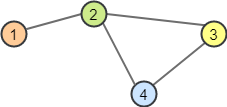</center>

The vertices are $V=\{1,2,3,4\}$, and edges $E=\{(1,2), (2,3), (2,4), (3,4)\}$. Note that for simplicity, we assume the graph to be undirected and hence don't add mirrored pairs like $(2,1)$. In application, vertices and edge can often have specific attributes, and edges can even be directed. The question is how we could represent this diversity in an efficient way for matrix operations. Usually, for the edges, we decide between two variants: an adjacency matrix, or a list of paired vertex indices. 

The **adjacency matrix** $A$ is a square matrix whose elements indicate whether pairs of vertices are adjacent, i.e. connected, or not. In the simplest case, $A_{ij}$ is 1 if there is a connection from node $i$ to $j$, and otherwise 0. If we have edge attributes or different categories of edges in a graph, this information can be added to the matrix as well. For an undirected graph, keep in mind that $A$ is a symmetric matrix ($A_{ij}=A_{ji}$). For the example graph above, we have the following adjacency matrix:

$$
A = \begin{bmatrix}
    0 & 1 & 0 & 0\\
    1 & 0 & 1 & 1\\
    0 & 1 & 0 & 1\\
    0 & 1 & 1 & 0
\end{bmatrix}
$$

While expressing a graph as a list of edges is more efficient in terms of memory and (possibly) computation, using an adjacency matrix is more intuitive and simpler to implement. In our implementations below, we will rely on the adjacency matrix to keep the code simple. However, common libraries use edge lists, which we will discuss later more.
Alternatively, we could also use the list of edges to define a sparse adjacency matrix with which we can work as if it was a dense matrix, but allows more memory-efficient operations. PyTorch supports this with the sub-package `torch.sparse` ([documentation](https://pytorch.org/docs/stable/sparse.html)) which is however still in a beta-stage (API might change in future).

## Graph Convolutions

Graph Convolutional Networks have been introduced by [Kipf et al.](https://openreview.net/pdf?id=SJU4ayYgl) in 2016 at the University of Amsterdam. He also wrote a great [blog post](https://tkipf.github.io/graph-convolutional-networks/) about this topic, which is recommended if you want to read about GCNs from a different perspective. GCNs are similar to convolutions in images in the sense that the "filter" parameters are typically shared over all locations in the graph. At the same time, GCNs rely on message passing methods, which means that vertices exchange information with the neighbors, and send "messages" to each other. Before looking at the math, we can try to visually understand how GCNs work. The first step is that each node creates a feature vector that represents the message it wants to send to all its neighbors. In the second step, the messages are sent to the neighbors, so that a node receives one message per adjacent node. Below we have visualized the two steps for our example graph. 

<center width="80%">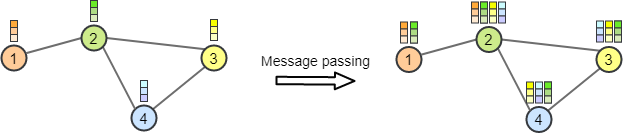</center>

If we want to formulate that in more mathematical terms, we need to first decide how to combine all the messages a node receives. As the number of messages vary across nodes, we need an operation that works for any number. Hence, the usual way to go is to sum or take the mean. Given the previous features of nodes $H^{(l)}$, the GCN layer is defined as follows:

$$H^{(l+1)} = \sigma\left(\hat{D}^{-1/2}\hat{A}\hat{D}^{-1/2}H^{(l)}W^{(l)}\right)$$

$W^{(l)}$ is the weight parameters with which we transform the input features into messages ($H^{(l)}W^{(l)}$). To the adjacency matrix $A$ we add the identity matrix so that each node sends its own message also to itself: $\hat{A}=A+I$. Finally, to take the average instead of summing, we calculate the matrix $\hat{D}$ which is a diagonal matrix with $D_{ii}$ denoting the number of neighbors node $i$ has. $\sigma$ represents an arbitrary activation function, and not necessarily the sigmoid (usually a ReLU-based activation function is used in GNNs). 

When implementing the GCN layer in PyTorch, we can take advantage of the flexible operations on tensors. Instead of defining a matrix $\hat{D}$, we can simply divide the summed messages by the number of neighbors afterward. Additionally, we replace the weight matrix with a linear layer, which additionally allows us to add a bias. Written as a PyTorch module, the GCN layer is defined as follows:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [ ]:
class GCNLayer(nn.Module):
    
    def __init__(self, c_in, c_out):
        super().__init__()
        self.projection = nn.Linear(c_in, c_out)

    def forward(self, node_feats, adj_matrix):
        """
        Inputs:
            node_feats - Tensor with node features of shape [batch_size, num_nodes, c_in]
            adj_matrix - Batch of adjacency matrices of the graph. If there is an edge from i to j, adj_matrix[b,i,j]=1 else 0.
                         Supports directed edges by non-symmetric matrices. Assumes to already have added the identity connections. 
                         Shape: [batch_size, num_nodes, num_nodes]
        """
        # Num neighbours = number of incoming edges
        num_neighbours = adj_matrix.sum(dim=-1, keepdims=True)
        node_feats = self.projection(node_feats)
        node_feats = torch.bmm(adj_matrix, node_feats)
        node_feats = node_feats / num_neighbours
        return node_feats

To further understand the GCN layer, we can apply it to our example graph above. First, let's specify some node features and the adjacency matrix with added self-connections:

In [ ]:
node_feats = torch.arange(8, dtype=torch.float32).view(1, 4, 2)
adj_matrix = torch.Tensor([[[1, 1, 0, 0],
                            [1, 1, 1, 1],
                            [0, 1, 1, 1],
                            [0, 1, 1, 1]]])

print("Node features:\n", node_feats)
print("\nAdjacency matrix:\n", adj_matrix)

Node features:
 tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

Adjacency matrix:
 tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])


Next, let's apply a GCN layer to it. For simplicity, we initialize the linear weight matrix as an identity matrix so that the input features are equal to the messages. This makes it easier for us to verify the message passing operation.

In [ ]:
layer = GCNLayer(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


Next, let's apply a GCN layer to it. For simplicity, we initialize the linear weight matrix as an identity matrix so that the input features are equal to the messages. This makes it easier for us to verify the message passing operation.

In [ ]:
layer = GCNLayer(c_in=2, c_out=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1., 2.],
         [3., 4.],
         [4., 5.],
         [4., 5.]]])


As we can see, the first node's output values are the average of itself and the second node. Similarly, we can verify all other nodes. However, in a GNN, we would also want to allow feature exchange between nodes beyond its neighbors. This can be achieved by applying multiple GCN layers, which gives us the final layout of a GNN. The GNN can be build up by a sequence of GCN layers and non-linearities such as ReLU. For a visualization, see below (figure credit - [Thomas Kipf, 2016](https://tkipf.github.io/graph-convolutional-networks/)).

<center width="100%" style="padding: 10px">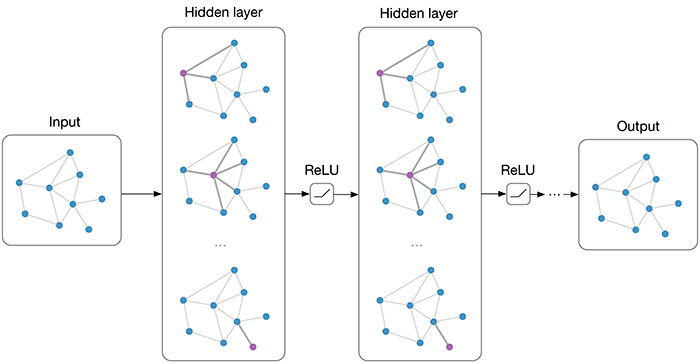</center>

However, one issue we can see from looking at the example above is that the output features for nodes 3 and 4 are the same because they have the same adjacent nodes (including itself). Therefore, GCN layers can make the network forget node-specific information if we just take a mean over all messages. Multiple possible improvements have been proposed. While the simplest option might be using residual connections, the more common approach is to either weigh the self-connections higher or define a separate weight matrix for the self-connections. Alternatively, we can re-visit a familiar concept: attention. 

## Graph Attention 

If you remember from the last tutorial, attention describes a weighted average of multiple elements with the weights dynamically computed based on an input query and elements' keys (if you haven't read Tutorial 6 yet, it is recommended to at least go through the very first section called [What is Attention?](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/tutorial6/Transformers_and_MHAttention.html#What-is-Attention?)). This concept can be similarly applied to graphs, one of such is the Graph Attention Network (called GAT, proposed by [Velickovic et al., 2017](https://arxiv.org/abs/1710.10903)). Similarly to the GCN, the graph attention layer creates a message for each node using a linear layer/weight matrix. For the attention part, it uses the message from the node itself as a query, and the messages to average as both keys and values (note that this also includes the message to itself). The score function $f_{attn}$ is implemented as a one-layer MLP which maps the query and key to a single value. The MLP looks as follows (figure credit - [Velickovic et al.](https://arxiv.org/abs/1710.10903)):

<center width="100%" style="padding:10px">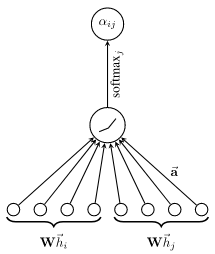</center>

$h_i$ and $h_j$ are the original features from node $i$ and $j$ respectively, and represent the messages of the layer with $\mathbf{W}$ as weight matrix. $\mathbf{a}$ is the weight matrix of the MLP, which has the shape $[1,2\times d_{\text{message}}]$, and $\alpha_{ij}$ the final attention weight from node $i$ to $j$. The calculation can be described as follows:

$$\alpha_{ij} = \frac{\exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\text{LeakyReLU}\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)\right)}$$

The operator $||$ represents the concatenation, and $\mathcal{N}_i$ the indices of the neighbors of node $i$. Note that in contrast to usual practice, we apply a non-linearity (here LeakyReLU) before the softmax over elements. Although it seems like a minor change at first, it is crucial for the attention to depend on the original input. Specifically, let's remove the non-linearity for a second, and try to simplify the expression:

$$
\begin{split}
    \alpha_{ij} & = \frac{\exp\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_j\right]\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}\left[\mathbf{W}h_i||\mathbf{W}h_k\right]\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i+\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i+\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i\right)\cdot\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,:d/2}\mathbf{W}h_i\right)\cdot\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\[5pt]
    & = \frac{\exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_j\right)}{\sum_{k\in\mathcal{N}_i} \exp\left(\mathbf{a}_{:,d/2:}\mathbf{W}h_k\right)}\\
\end{split}
$$

We can see that without the non-linearity, the attention term with $h_i$ actually cancels itself out, resulting in the attention being independent of the node itself. Hence, we would have the same issue as the GCN of creating the same output features for nodes with the same neighbors. This is why the LeakyReLU is crucial and adds some dependency on $h_i$ to the attention. 

Once we obtain all attention factors, we can calculate the output features for each node by performing the weighted average:

$$h_i'=\sigma\left(\sum_{j\in\mathcal{N}_i}\alpha_{ij}\mathbf{W}h_j\right)$$

$\sigma$ is yet another non-linearity, as in the GCN layer. Visually, we can represent the full message passing in an attention layer as follows (figure credit - [Velickovic et al.](https://arxiv.org/abs/1710.10903)):

<center width="100%">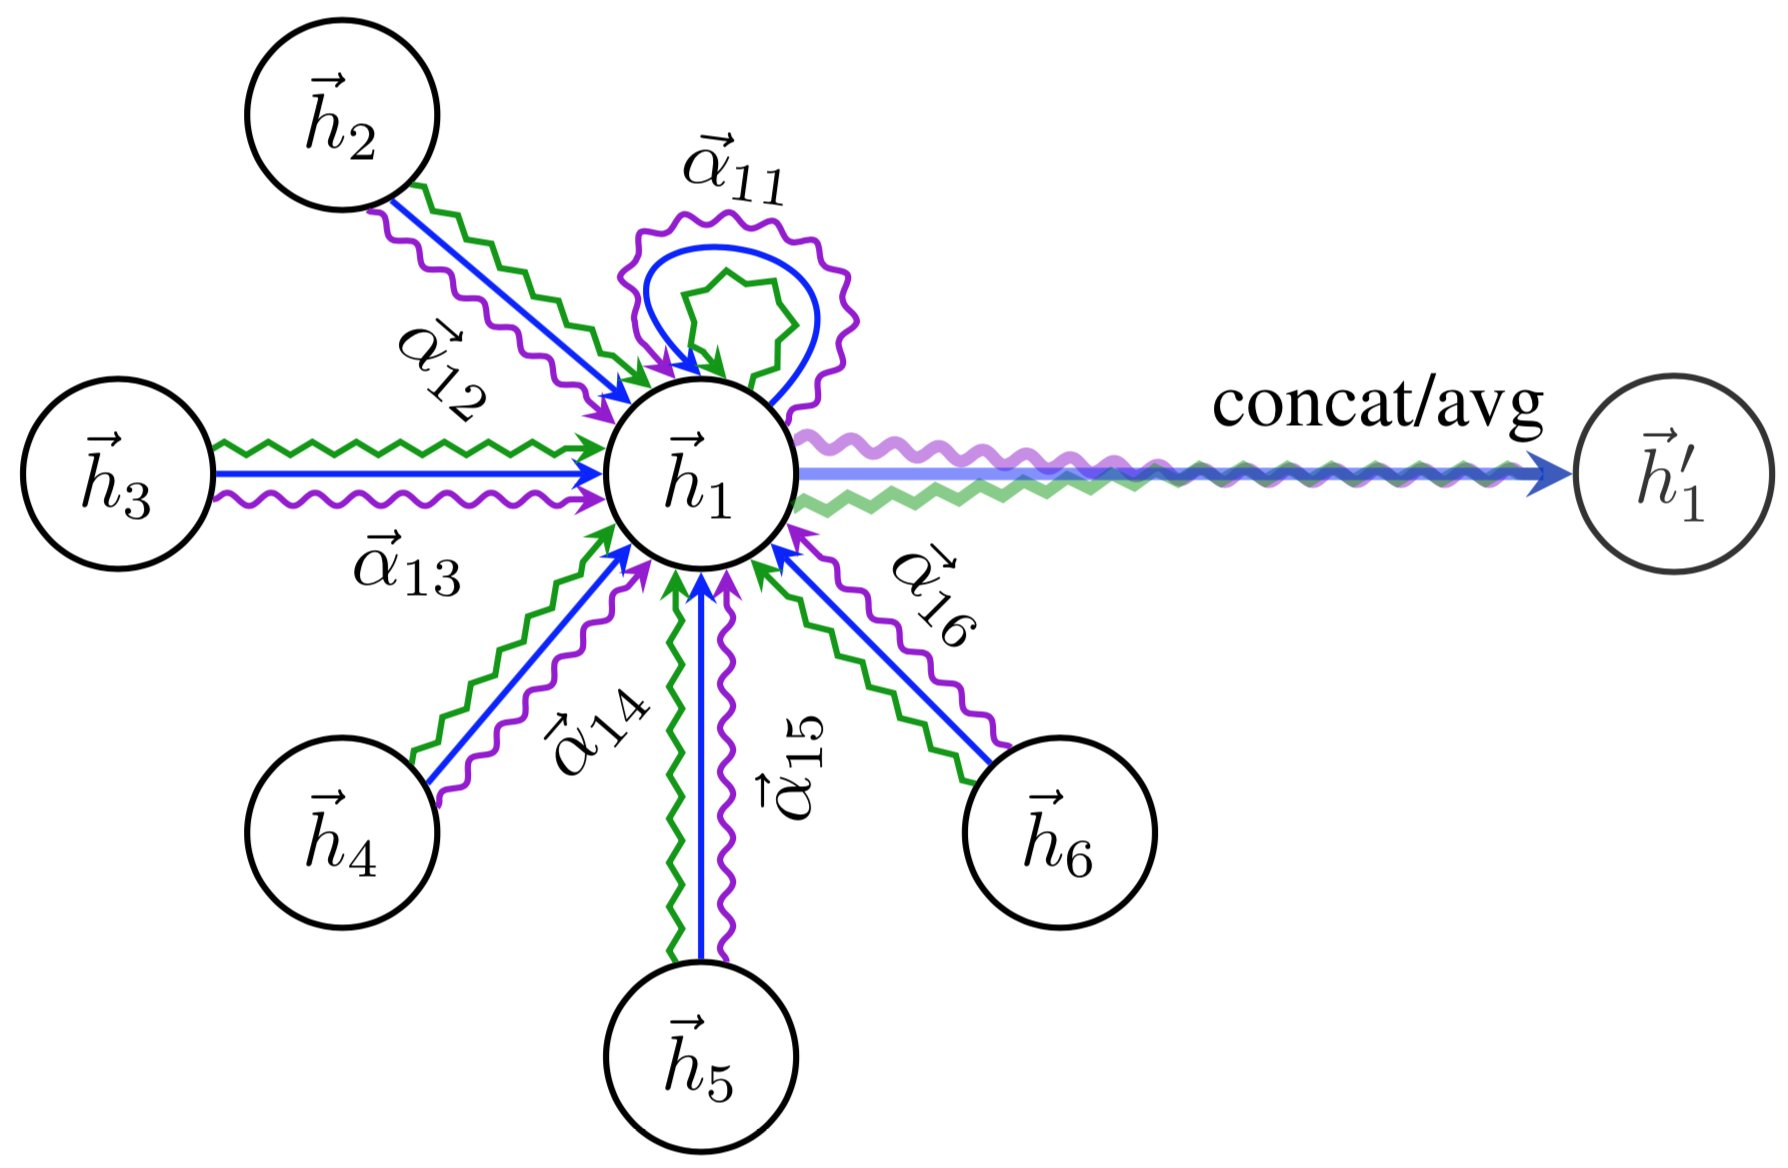</center>

To increase the expressiveness of the graph attention network, [Velickovic et al.](https://arxiv.org/abs/1710.10903) proposed to extend it to multiple heads similar to the Multi-Head Attention block in Transformers. This results in $N$ attention layers being applied in parallel. In the image above, it is visualized as three different colors of arrows (green, blue, and purple) that are afterward concatenated. The average is only applied for the very final prediction layer in a network. 

After having discussed the graph attention layer in detail, we can implement it below:

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

In [ ]:
class GATLayer(nn.Module):
    
    def __init__(self, c_in, c_out, num_heads=1, concat_heads=True, alpha=0.2):
        """
        Inputs:
            c_in - Dimensionality of input features
            c_out - Dimensionality of output features
            num_heads - Number of heads, i.e. attention mechanisms to apply in parallel. The 
                        output features are equally split up over the heads if concat_heads=True.
            concat_heads - If True, the output of the different heads is concatenated instead of averaged.
            alpha - Negative slope of the LeakyReLU activation.
        """
        super().__init__()
        self.num_heads = num_heads
        self.concat_heads = concat_heads
        if self.concat_heads:
            assert c_out % num_heads == 0, "Number of output features must be a multiple of the count of heads."
            c_out = c_out // num_heads
        
        # Sub-modules and parameters needed in the layer
        self.projection = nn.Linear(c_in, c_out * num_heads)
        self.a = nn.Parameter(torch.Tensor(num_heads, 2 * c_out)) # One per head
        self.leakyrelu = nn.LeakyReLU(alpha)
        
        # Initialization from the original implementation
        nn.init.xavier_uniform_(self.projection.weight.data, gain=1.414)
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        
    def forward(self, node_feats, adj_matrix, print_attn_probs=False):
        """
        Inputs:
            node_feats - Input features of the node. Shape: [batch_size, c_in]
            adj_matrix - Adjacency matrix including self-connections. Shape: [batch_size, num_nodes, num_nodes]
            print_attn_probs - If True, the attention weights are printed during the forward pass (for debugging purposes)
        """
        batch_size, num_nodes = node_feats.size(0), node_feats.size(1)
        
        # Apply linear layer and sort nodes by head
        node_feats = self.projection(node_feats)
        node_feats = node_feats.view(batch_size, num_nodes, self.num_heads, -1)
        
        # We need to calculate the attention logits for every edge in the adjacency matrix 
        # Doing this on all possible combinations of nodes is very expensive
        # => Create a tensor of [W*h_i||W*h_j] with i and j being the indices of all edges
        edges = adj_matrix.nonzero(as_tuple=False) # Returns indices where the adjacency matrix is not 0 => edges
        node_feats_flat = node_feats.view(batch_size * num_nodes, self.num_heads, -1)
        edge_indices_row = edges[:,0] * num_nodes + edges[:,1]
        edge_indices_col = edges[:,0] * num_nodes + edges[:,2]
        a_input = torch.cat([
            torch.index_select(input=node_feats_flat, index=edge_indices_row, dim=0),
            torch.index_select(input=node_feats_flat, index=edge_indices_col, dim=0)
        ], dim=-1) # Index select returns a tensor with node_feats_flat being indexed at the desired positions along dim=0
        
        # Calculate attention MLP output (independent for each head)
        attn_logits = torch.einsum('bhc,hc->bh', a_input, self.a) 
        attn_logits = self.leakyrelu(attn_logits)
        
        # Map list of attention values back into a matrix
        attn_matrix = attn_logits.new_zeros(adj_matrix.shape+(self.num_heads,)).fill_(-9e15)
        attn_matrix[adj_matrix[...,None].repeat(1,1,1,self.num_heads) == 1] = attn_logits.reshape(-1)
        
        # Weighted average of attention
        attn_probs = F.softmax(attn_matrix, dim=2)
        if print_attn_probs:
            print("Attention probs\n", attn_probs.permute(0, 3, 1, 2))
        node_feats = torch.einsum('bijh,bjhc->bihc', attn_probs, node_feats)
        
        # If heads should be concatenated, we can do this by reshaping. Otherwise, take mean
        if self.concat_heads:
            node_feats = node_feats.reshape(batch_size, num_nodes, -1)
        else:
            node_feats = node_feats.mean(dim=2)
        
        return node_feats 

Again, we can apply the graph attention layer on our example graph above to understand the dynamics better. As before, the input layer is initialized as an identity matrix, but we set $\mathbf{a}$ to be a vector of arbitrary numbers to obtain different attention values. We use two heads to show the parallel, independent attention mechanisms working in the layer.

In [ ]:
layer = GATLayer(2, 2, num_heads=2)
layer.projection.weight.data = torch.Tensor([[1., 0.], [0., 1.]])
layer.projection.bias.data = torch.Tensor([0., 0.])
layer.a.data = torch.Tensor([[-0.2, 0.3], [0.1, -0.1]])

with torch.no_grad():
    out_feats = layer(node_feats, adj_matrix, print_attn_probs=True)

print("Adjacency matrix", adj_matrix)
print("Input features", node_feats)
print("Output features", out_feats)

Attention probs
 tensor([[[[0.3543, 0.6457, 0.0000, 0.0000],
          [0.1096, 0.1450, 0.2642, 0.4813],
          [0.0000, 0.1858, 0.2885, 0.5257],
          [0.0000, 0.2391, 0.2696, 0.4913]],

         [[0.5100, 0.4900, 0.0000, 0.0000],
          [0.2975, 0.2436, 0.2340, 0.2249],
          [0.0000, 0.3838, 0.3142, 0.3019],
          [0.0000, 0.4018, 0.3289, 0.2693]]]])
Adjacency matrix tensor([[[1., 1., 0., 0.],
         [1., 1., 1., 1.],
         [0., 1., 1., 1.],
         [0., 1., 1., 1.]]])
Input features tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])
Output features tensor([[[1.2913, 1.9800],
         [4.2344, 3.7725],
         [4.6798, 4.8362],
         [4.5043, 4.7351]]])


We recommend that you try to calculate the attention matrix at least for one head and one node for yourself. The entries are 0 where there does not exist an edge between $i$ and $j$. For the others, we see a diverse set of attention probabilities. Moreover, the output features of node 3 and 4 are now different although they have the same neighbors.

## Convolution Fundamentals

**Why convolution in ML?**

- Weight sharing
- Detection of translational invariant and local features

![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/Convolution_of_box_signal_with_itself2.gif?raw=1)

[Source](https://en.wikipedia.org/wiki/File:Convolution_of_box_signal_with_itself2.gif)

### Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})

### Definition

\begin{align*}
c[n] = (v * w)[n] = \sum_{m=0}^{N-1} v[m] \cdot w[n-m]
\end{align*}

In [ ]:
def conv(v, w):
    c = np.zeros(v.shape)
    for n in range(len(v)):
        c[n] = 0
        for m in range(len(v)):
            c[n] += v[m] * w[n - m]  
    return c

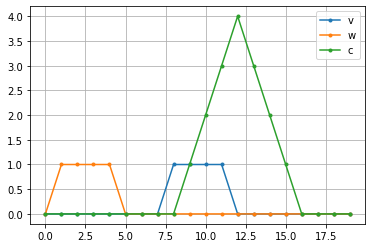

In [ ]:
N = 20
v = np.zeros(N)
v[8:12] = 1
w = np.zeros(N)
w[1:5] = 1
c = conv(v, w)

fig = plt.figure()
ax = fig.gca()
ax.plot(v, '.-')
ax.plot(w, '.-')
ax.plot(c, '.-')
ax.legend(['v', 'w', 'c'])
ax.grid(True)

### Fourier transform

Transformation $\mathcal F: \mathbb{R}^N \to \mathbb{R}^N$ with

\begin{align*}
\mathcal F^{-1}(\mathcal F (v)) &= v\\
\mathcal F(v * w) &= \mathcal F(v) \cdot \mathcal F(w).
\end{align*}

This implies
\begin{align*}
v * w &= \mathcal F^{-1}(\mathcal F (v * w))\\
&= \mathcal F^{-1}(\mathcal F(v) \cdot \mathcal F(w))
\end{align*}

In [ ]:
v, w = np.random.rand(N), np.random.rand(N)
conv(v, w)

array([4.77844055, 4.16890293, 4.2094015 , 4.85675858, 4.06215214,
       3.90872955, 4.57520226, 4.46153879, 4.53669411, 4.82854389,
       4.3837407 , 4.04920654, 5.03368611, 3.95014887, 4.30986943,
       4.30560994, 4.08024085, 4.17150078, 4.49179264, 4.15049511])

In [ ]:
from scipy.fft import fft, ifft # Fast Fourier Transform / Inverse FFT
np.abs(ifft(fft(v) * fft(w)))

array([4.77844055, 4.16890293, 4.2094015 , 4.85675858, 4.06215214,
       3.90872955, 4.57520226, 4.46153879, 4.53669411, 4.82854389,
       4.3837407 , 4.04920654, 5.03368611, 3.95014887, 4.30986943,
       4.30560994, 4.08024085, 4.17150078, 4.49179264, 4.15049511])

#### Definition of the Fourier transform

The Fourier transform can be computed as

\begin{align*}
\mathcal F(v) = U\cdot v, \;\;\mathcal F^{-1}(v) = \frac{1}{N}\ U^H \cdot v
\end{align*}

where the $N\times N$ matrix $U$ is defined as
\begin{align*}
\\
U = 
\begin{bmatrix}
u_0(0) & u_1(0) & \dots & u_{N-1}(0)\\
u_0(1) & u_1(1) & \dots & u_{N-1}(1)\\
\vdots & \vdots& & \vdots\\
u_0(N-1) & u_1(N-1) & \dots & u_{N-1}(N-1)\\
\end{bmatrix} 
\end{align*}

and $u_0, \dots, u_{N-1}$ are functions defined as

\begin{align*}
u_n(x)&:= \cos\left(2 \pi \frac{n}{N} x\right) - i \sin\left(2 \pi \frac{n}{N} x\right).
\end{align*}

In [ ]:
def matrix_U(N):
    u = lambda n, N: np.cos(2 * np.pi / N * n * np.arange(N)) - 1j * np.sin(2 * np.pi / N * n * np.arange(N))
    U = np.empty((N, 0))
    for n in range(N):
        U = np.c_[U, u(n, N)]
    return U


def fourier_transform(v):
    N = v.shape[0]
    U = matrix_U(N)
    return U @ v


def inverse_fourier_transform(v):
    N = v.shape[0]
    U = matrix_U(N)
    return (U.conj().transpose() @ v) / N

In [ ]:
fft(v) - fourier_transform(v)

array([-1.77635684e-15-0.00000000e+00j,  6.66133815e-16-2.22044605e-16j,
        0.00000000e+00-1.66533454e-16j,  9.99200722e-16+6.66133815e-16j,
       -1.11022302e-16+5.55111512e-16j,  3.55271368e-15+6.10622664e-16j,
       -1.55431223e-15+9.99200722e-16j, -6.60582700e-15+0.00000000e+00j,
       -1.11022302e-16-2.49800181e-16j,  6.66133815e-16-2.22044605e-16j,
        4.44089210e-16+4.08296952e-15j,  3.16413562e-15-1.77635684e-15j,
       -1.11022302e-15-1.30451205e-15j,  2.22044605e-16-3.55271368e-15j,
       -4.44089210e-16+5.21804822e-15j,  4.66293670e-15+5.38458167e-15j,
        0.00000000e+00+1.55431223e-15j, -6.55031585e-15-3.77475828e-15j,
        5.32907052e-15+3.38618023e-15j, -4.88498131e-15-1.33226763e-15j])

In [ ]:
ifft(v) - inverse_fourier_transform(v)

array([ 0.00000000e+00-0.00000000e+00j,  4.16333634e-17+0.00000000e+00j,
        0.00000000e+00+3.46944695e-18j,  4.85722573e-17-5.55111512e-17j,
       -1.73472348e-17-2.08166817e-17j,  1.73472348e-16-2.77555756e-17j,
       -9.02056208e-17-6.24500451e-17j, -3.22658567e-16+0.00000000e+00j,
       -6.93889390e-18+1.04083409e-17j,  2.42861287e-17+0.00000000e+00j,
       -4.16333634e-17-2.04148476e-16j,  1.45716772e-16+9.71445147e-17j,
       -5.55111512e-17+6.41847686e-17j,  6.93889390e-18+1.66533454e-16j,
       -3.46944695e-17-2.70616862e-16j,  2.32452946e-16-2.67147415e-16j,
        1.73472348e-17-7.63278329e-17j, -3.19189120e-16+2.04697370e-16j,
        2.53269627e-16-1.59594560e-16j, -2.22044605e-16+9.71445147e-17j])

#### Connection with the Laplacian

The functions $u_n$ (the columns of the Fourier transform matrix) are eigenvectors of the Laplacian:

\begin{align*}
u_n(x)&:= \cos\left(2 \pi \frac{n}{N} x\right) - i \sin\left(2 \pi \frac{n}{N} x\right)\\
\Delta u_n(x)&:= \left(-4 \pi\frac{n^2}{N^2}\right) u_n(x)
\end{align*}

#### Summary

\begin{align*}
v * w 
= U^H ((U  w) \odot (U  v))
\end{align*}

or if $g_w=\mbox{diag}(U w)$ is  filter
\begin{align*}
v * w 
= U^H g_w U  w
\end{align*}

In [ ]:
U = matrix_U(N)
np.abs((U.conj().transpose() / N) @ ((U @ v) * (U @ w)))

array([4.77844055, 4.16890293, 4.2094015 , 4.85675858, 4.06215214,
       3.90872955, 4.57520226, 4.46153879, 4.53669411, 4.82854389,
       4.3837407 , 4.04920654, 5.03368611, 3.95014887, 4.30986943,
       4.30560994, 4.08024085, 4.17150078, 4.49179264, 4.15049511])

In [ ]:
conv(v, w)

array([4.77844055, 4.16890293, 4.2094015 , 4.85675858, 4.06215214,
       3.90872955, 4.57520226, 4.46153879, 4.53669411, 4.82854389,
       4.3837407 , 4.04920654, 5.03368611, 3.95014887, 4.30986943,
       4.30560994, 4.08024085, 4.17150078, 4.49179264, 4.15049511])

### Convolution on graphs

**Plan**:
- Define the graph Laplacian
- Compute the spectrum
- Define a Fourier transform
- Define convolution on a graph

**Note:** From now on $G = (V, E)$ is an undirected, unweighted, simple graph.

#### Graph Laplacian

Adjacency matrix
\begin{align*}
A_{ij} = \left\{
    \begin{array}{ll}
    1 &\text{ if } e_{ij}\in E\\
    0 &\text{ if } e_{ij}\notin E
    \end{array}
    \right.
\end{align*}

Degree matrix
\begin{align*}
D_{ij} = \left\{
    \begin{array}{ll}
    \mbox{deg}(v_i) &\text{ if } i=j\\
    0 &\text{ if } i\neq j
    \end{array}
    \right.
\end{align*}

Laplacian
\begin{align*}
L &= D - A.
\end{align*}

Normalized Laplacian
\begin{align*}
L &= I - D^{-1/2} A D^{-1/2}.
\end{align*}

#### Graph spectrum, Fourier transform, and convolution

1. Spectral decomposition of the Laplacian:
\begin{align*}
L = U \Lambda U^T\\
\end{align*}


2. Fourier transform: if $v$ is a vector of features on the graph, then
\begin{align*}
\mathcal F (v) = U \cdot v, \;\;\mathcal F^{-1} (v) = U^T \cdot v\\
\end{align*}


3. Convolution with a filter $U \cdot w$
\begin{align*}
v * w = U ((U^T  w) \odot (U^T  v) )
\end{align*}


Or $g_w = \mbox{diag}(U^T w)$ is a filter, then
\begin{align*}
v * w = U g_w U^T  v
\end{align*}


## Spectral-convolutional layers in PyTorch Geometric

**Problem:** Computing the spectrum is a global and very expensive property.

**Goal:** Implementation as message passing.

### ChebConv

- Original [paper](https://arxiv.org/pdf/1606.09375.pdf)
- PyTorch [doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.ChebConv)

#### Goal: 
Compute $U g_w U^T x$ with $g_w = g_w(\Lambda)$ a filter.

#### Chebyshev approximation

Chebyshev polynomials $T_k$:
\begin{align*}
T_{k}(x) = 2 x T_{k-1}(x) - T_{k-2}(x), \;\; T_0(x) = 1, T_1(x) = x
\end{align*}

#### Chebyshev approximation of the filter
Aproximation of the filter:
\begin{align*}
g_w(\Lambda) = \sum_{k=0}^K \theta_k T_k(\tilde \Lambda),\;\;\;\;\tilde \Lambda = \frac{2}{\lambda_\max} \Lambda - I \cdot \lambda_\max
\end{align*}


#### Property
If $L = U \Lambda U^T$ then $T_k(L) = U T_k(\Lambda) U^T$.


#### Fast approximated convolution 
\begin{align*}
v * w &= U g_w U^T x
= U \left(\sum_{k=0}^K \theta_k T_k(\tilde \Lambda) \right)U^T x
=\sum_{k=0}^K  \theta_k U  T_k(\tilde \Lambda) U^T x\\ 
&=\sum_{k=0}^K  \theta_k T_k(\tilde L) x 
\end{align*}

\begin{align*}
\tilde L = \frac{2}{\lambda_\max} L - I
\end{align*}

#### Properties:
- Depends on $L$ and $\lambda_\max$, not on $U, \Sigma$
- Uses only $K$-powers $\Rightarrow$ only the $K$-th neighborhood of each node, localized filter

**As message passing:**

![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/cheb_init.png?raw=1)


![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/cheb_norm.png?raw=1)


![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/cheb_forward.png?raw=1)


![](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/cheb_message.png?raw=1)

### GCNConv

- Original [paper](https://arxiv.org/pdf/1609.02907.pdf)
- PyTorch [doc](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv)

Start from `ChebConv` and assume 
1. $K=1$ (linear approximation) so
\begin{align*}
v * w 
&=\sum_{k=0}^1  \theta_k T_k(\tilde L) x
= \theta_0 x + \theta_1 \tilde L x\\
\end{align*}

2. $\lambda_\max =2$ so
\begin{align*}
v * w 
&= \theta_0 x + \theta_1 (L - I) x\\
&= \theta_0 x - \theta_1 D^{-1/2} A D^{1/2} x\\
\end{align*}


3. $\theta_0=-\theta_1= \theta$ so 
\begin{align*}
v * w = \left(I + D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}

4. Renormalization of $\theta$ by using 
\begin{align*}
\tilde A&:= I + A\\
\tilde D_{ii}&:= \sum_j \tilde A_{ij}
\end{align*}
so 
\begin{align*}
v * w = \left(D^{-1/2} A D^{1/2}\right) x \theta
\end{align*}

If $x$ is a $F$-dimensional feature vector, and we want an $F'$-dimensional feature vector as output:
use $W'\in \mathbb{R}^{F\times F'}$
\begin{align*}
v * w = \left(D^{-1/2} A D^{1/2}\right) x \Theta
\end{align*}


Nodewise:

![image.png](https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial4/fig/gcn_nodewise.png?raw=1)

## Aggregation Functions in GNNs

### Context

We explore how to perform neighborhood aggregation in GNNs, describing the GIN model and other recent techniques for selecting the right aggregation (PNA) or learn it (LAF).

We will override the aggregation method of the GIN convolution module of Pytorch Geometric implementing the following methods:

- Principal Neighborhood Aggregation (PNA)
- Learning Aggregation Functions (LAF)

### WL Isomorphism Test

**Step 1**

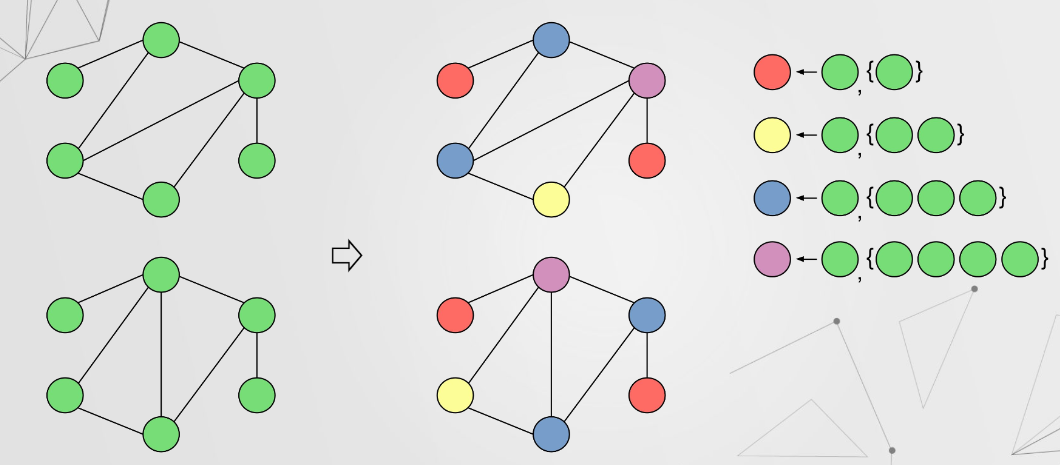

**Step 2**

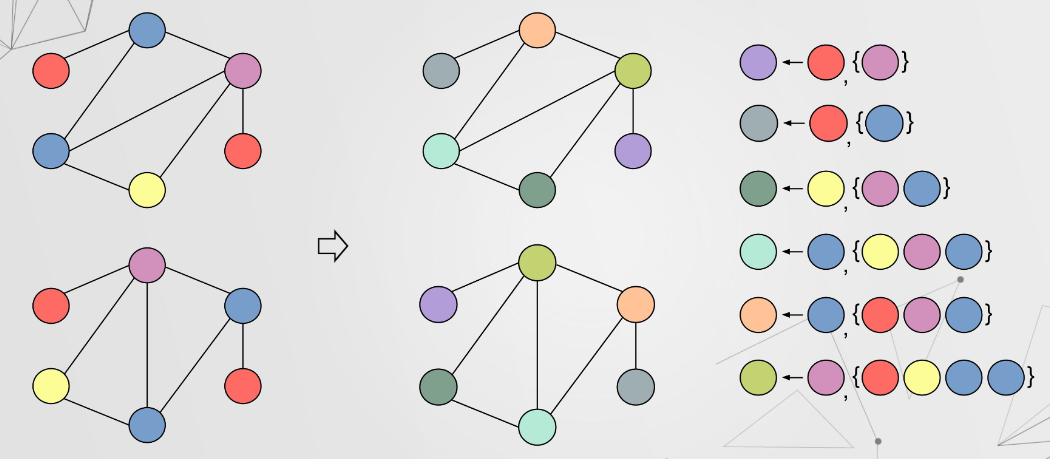

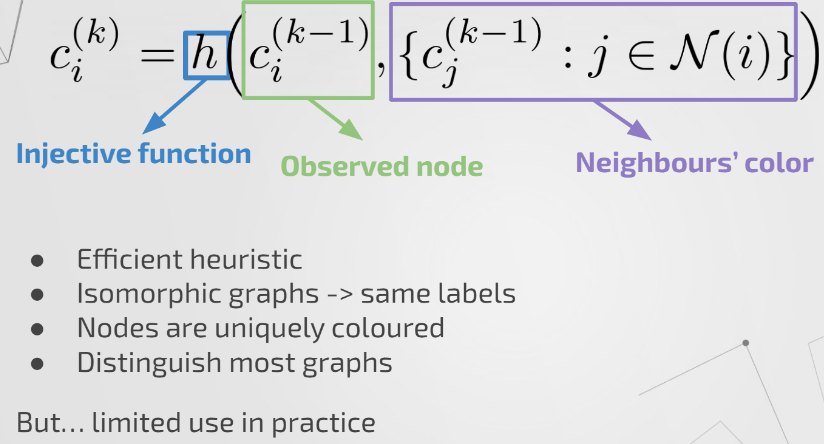

### Imports

In [ ]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.nn import GINConv
from torch.nn import Linear
from torch_geometric.nn import MessagePassing, SAGEConv, GINConv, global_add_pool
import torch_scatter
import torch.nn.functional as F
from torch.nn import Sequential, Linear, ReLU
from torch_geometric.datasets import TUDataset
from torch_geometric.data import DataLoader
from torch.nn import Parameter, Module, Sigmoid
import os.path as osp

torch.manual_seed(42)

### Message Passing Class

We are interested in the <span style='color:Blue'>aggregate</span> method, or, if you are using a sparse adjacency matrix, in the <span style='color:Blue'>message_and_aggregate</span> method. Convolutional classes in PyG extend MessagePassing, we construct our custom convoutional class extending GINConv.

Scatter operation in <span style='color:Blue'>aggregate</span>:

<img src="https://raw.githubusercontent.com/rusty1s/pytorch_scatter/master/docs/source/_figures/add.svg?sanitize=true" width="500">

### LAF Aggregation Module

<img src="https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial5/laf.png?raw=true" width="500">

**LAF Layer**

In [ ]:
class AbstractLAFLayer(Module):
    def __init__(self, **kwargs):
        super(AbstractLAFLayer, self).__init__()
        assert 'units' in kwargs or 'weights' in kwargs
        if 'device' in kwargs.keys():
            self.device = kwargs['device']
        else:
            self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.ngpus = torch.cuda.device_count()
        
        if 'kernel_initializer' in kwargs.keys():
            assert kwargs['kernel_initializer'] in [
                'random_normal',
                'glorot_normal',
                'he_normal',
                'random_uniform',
                'glorot_uniform',
                'he_uniform']
            self.kernel_initializer = kwargs['kernel_initializer']
        else:
            self.kernel_initializer = 'random_normal'

        if 'weights' in kwargs.keys():
            self.weights = Parameter(kwargs['weights'].to(self.device), \
                                     requires_grad=True)
            self.units = self.weights.shape[1]
        else:
            self.units = kwargs['units']
            params = torch.empty(12, self.units, device=self.device)
            if self.kernel_initializer == 'random_normal':
                torch.nn.init.normal_(params)
            elif self.kernel_initializer == 'glorot_normal':
                torch.nn.init.xavier_normal_(params)
            elif self.kernel_initializer == 'he_normal':
                torch.nn.init.kaiming_normal_(params)
            elif self.kernel_initializer == 'random_uniform':
                torch.nn.init.uniform_(params)
            elif self.kernel_initializer == 'glorot_uniform':
                torch.nn.init.xavier_uniform_(params)
            elif self.kernel_initializer == 'he_uniform':
                torch.nn.init.kaiming_uniform_(params)
            self.weights = Parameter(params, \
                                     requires_grad=True)
        e = torch.tensor([1,-1,1,-1], dtype=torch.float32, device=self.device)
        self.e = Parameter(e, requires_grad=False)
        num_idx = torch.tensor([1,1,0,0], dtype=torch.float32, device=self.device).\
                                view(1,1,-1,1)
        self.num_idx = Parameter(num_idx, requires_grad=False)
        den_idx = torch.tensor([0,0,1,1], dtype=torch.float32, device=self.device).\
                                view(1,1,-1,1)
        self.den_idx = Parameter(den_idx, requires_grad=False)
        

class LAFLayer(AbstractLAFLayer):
    def __init__(self, eps=1e-7, **kwargs):
        super(LAFLayer, self).__init__(**kwargs)
        self.eps = eps
    
    def forward(self, data, index, dim=0, **kwargs):
        eps = self.eps
        sup = 1.0 - eps 
        e = self.e

        x = torch.clamp(data, eps, sup)
        x = torch.unsqueeze(x, -1)
        e = e.view(1,1,-1)        

        exps = (1. - e)/2. + x*e 
        exps = torch.unsqueeze(exps, -1)
        exps = torch.pow(exps, torch.relu(self.weights[0:4]))

        scatter = torch_scatter.scatter_add(exps, index.view(-1), dim=dim)
        scatter = torch.clamp(scatter, eps)

        sqrt = torch.pow(scatter, torch.relu(self.weights[4:8]))
        alpha_beta = self.weights[8:12].view(1,1,4,-1)
        terms = sqrt * alpha_beta

        num = torch.sum(terms * self.num_idx, dim=2)
        den = torch.sum(terms * self.den_idx, dim=2)
        
        multiplier = 2.0*torch.clamp(torch.sign(den), min=0.0) - 1.0

        den = torch.where((den < eps) & (den > -eps), multiplier*eps, den)

        res = num / den
        return res

In [ ]:
class GINLAFConv(GINConv):
    def __init__(self, nn, units=1, node_dim=32, **kwargs):
        super(GINLAFConv, self).__init__(nn, **kwargs)
        self.laf = LAFLayer(units=units, kernel_initializer='random_uniform')
        self.mlp = torch.nn.Linear(node_dim*units, node_dim)
        self.dim = node_dim
        self.units = units
    
    def aggregate(self, inputs, index):
        x = torch.sigmoid(inputs)
        x = self.laf(x, index)
        x = x.view((-1, self.dim * self.units))
        x = self.mlp(x)
        return x

### PNA Aggregation

<img src="https://github.com/AntonioLonga/PytorchGeometricTutorial/blob/main/Tutorial5/pna.png?raw=true" width="800">

In [ ]:
class GINPNAConv(GINConv):
    def __init__(self, nn, node_dim=32, **kwargs):
        super(GINPNAConv, self).__init__(nn, **kwargs)
        self.mlp = torch.nn.Linear(node_dim*12, node_dim)
        self.delta = 2.5749
    
    def aggregate(self, inputs, index):
        sums = torch_scatter.scatter_add(inputs, index, dim=0)
        maxs = torch_scatter.scatter_max(inputs, index, dim=0)[0]
        means = torch_scatter.scatter_mean(inputs, index, dim=0)
        var = torch.relu(torch_scatter.scatter_mean(inputs ** 2, index, dim=0) - means ** 2)
        
        aggrs = [sums, maxs, means, var]
        c_idx = index.bincount().float().view(-1, 1)
        l_idx = torch.log(c_idx + 1.)
        
        amplification_scaler = [c_idx / self.delta * a for a in aggrs]
        attenuation_scaler = [self.delta / c_idx * a for a in aggrs]
        combinations = torch.cat(aggrs+ amplification_scaler+ attenuation_scaler, dim=1)
        x = self.mlp(combinations)
    
        return x

### Test the new classes

In [ ]:
path = osp.join('./', 'data', 'TU')
dataset = TUDataset(path, name='MUTAG').shuffle()
test_dataset = dataset[:len(dataset) // 10]
train_dataset = dataset[len(dataset) // 10:]
test_loader = DataLoader(test_dataset, batch_size=128)
train_loader = DataLoader(train_dataset, batch_size=128)

Extracting data/TU/MUTAG/MUTAG.zip
Processing...
Done!
/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


### LAF Model

In [ ]:
class LAFNet(torch.nn.Module):
    def __init__(self):
        super(LAFNet, self).__init__()

        num_features = dataset.num_features
        dim = 32
        units = 3
        
        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINLAFConv(nn1, units=units, node_dim=num_features)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINLAFConv(nn2, units=units, node_dim=dim)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINLAFConv(nn3, units=units, node_dim=dim)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINLAFConv(nn4, units=units, node_dim=dim)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINLAFConv(nn5, units=units, node_dim=dim)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)


### PNA Model

In [ ]:
class PNANet(torch.nn.Module):
    def __init__(self):
        super(PNANet, self).__init__()

        num_features = dataset.num_features
        dim = 32

        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINPNAConv(nn1, node_dim=num_features)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINPNAConv(nn2, node_dim=dim)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINPNAConv(nn3, node_dim=dim)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINPNAConv(nn4, node_dim=dim)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINPNAConv(nn5, node_dim=dim)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

### GIN Model

In [ ]:
class GINNet(torch.nn.Module):
    def __init__(self):
        super(GINNet, self).__init__()

        num_features = dataset.num_features
        dim = 32

        nn1 = Sequential(Linear(num_features, dim), ReLU(), Linear(dim, dim))
        self.conv1 = GINConv(nn1)
        self.bn1 = torch.nn.BatchNorm1d(dim)

        nn2 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv2 = GINConv(nn2)
        self.bn2 = torch.nn.BatchNorm1d(dim)

        nn3 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv3 = GINConv(nn3)
        self.bn3 = torch.nn.BatchNorm1d(dim)

        nn4 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv4 = GINConv(nn4)
        self.bn4 = torch.nn.BatchNorm1d(dim)

        nn5 = Sequential(Linear(dim, dim), ReLU(), Linear(dim, dim))
        self.conv5 = GINConv(nn5)
        self.bn5 = torch.nn.BatchNorm1d(dim)

        self.fc1 = Linear(dim, dim)
        self.fc2 = Linear(dim, dataset.num_classes)

    def forward(self, x, edge_index, batch):
        x = F.relu(self.conv1(x, edge_index))
        x = self.bn1(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.bn2(x)
        x = F.relu(self.conv3(x, edge_index))
        x = self.bn3(x)
        x = F.relu(self.conv4(x, edge_index))
        x = self.bn4(x)
        x = F.relu(self.conv5(x, edge_index))
        x = self.bn5(x)
        x = global_add_pool(x, batch)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=-1)

### Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = "PNA"
if net == "LAF":
    model = LAFNet().to(device)
elif net == "PNA":
    model = PNANet().to(device)
elif net == "GIN":
    GINNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train(epoch):
    model.train()

    if epoch == 51:
        for param_group in optimizer.param_groups:
            param_group['lr'] = 0.5 * param_group['lr']

    loss_all = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data.x, data.edge_index, data.batch)
        loss = F.nll_loss(output, data.y)
        loss.backward()
        loss_all += loss.item() * data.num_graphs
        optimizer.step()
    return loss_all / len(train_dataset)


def test(loader):
    model.eval()

    correct = 0
    for data in loader:
        data = data.to(device)
        output = model(data.x, data.edge_index, data.batch)
        pred = output.max(dim=1)[1]
        correct += pred.eq(data.y).sum().item()
    return correct / len(loader.dataset)

In [ ]:
for epoch in range(1, 101):
    train_loss = train(epoch)
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print('Epoch: {:03d}, Train Loss: {:.7f}, '
          'Train Acc: {:.7f}, Test Acc: {:.7f}'.format(epoch, train_loss,
                                                       train_acc, test_acc))

Epoch: 001, Train Loss: 1.3503007, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 002, Train Loss: 1.0256756, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 003, Train Loss: 0.8051956, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 004, Train Loss: 0.5679972, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 005, Train Loss: 0.6113488, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 006, Train Loss: 0.5096646, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 007, Train Loss: 0.5186039, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 008, Train Loss: 0.5086721, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 009, Train Loss: 0.4611959, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 010, Train Loss: 0.4153806, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 011, Train Loss: 0.3940109, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 012, Train Loss: 0.3995883, Train Acc: 0.6705882, Test Acc: 0.6111111
Epoch: 013, Train Loss: 0.4096542, Train Acc: 0.6705882, Test Acc: 0.6111111

In [ ]:
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

## Graph AutoEncoders - GAE & VGAE    

[paper](https://arxiv.org/pdf/1611.07308.pdf)  
[code](https://github.com/rusty1s/pytorch_geometric/blob/master/examples/autoencoder.py)

### Context

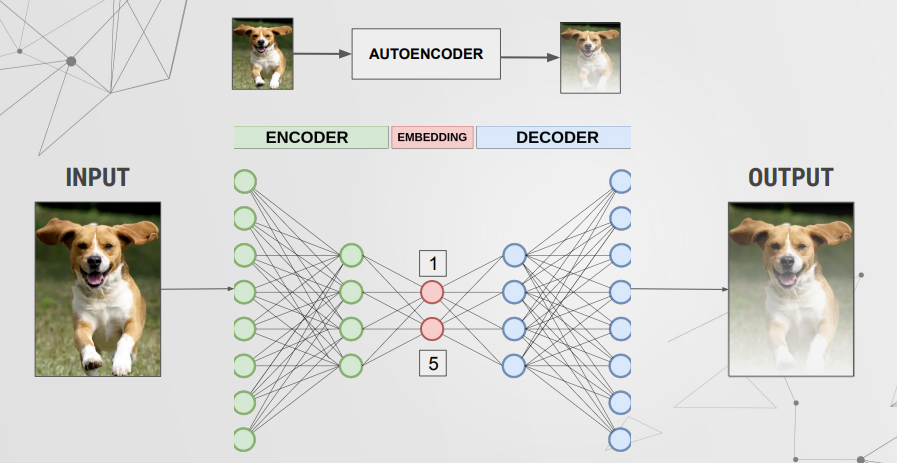

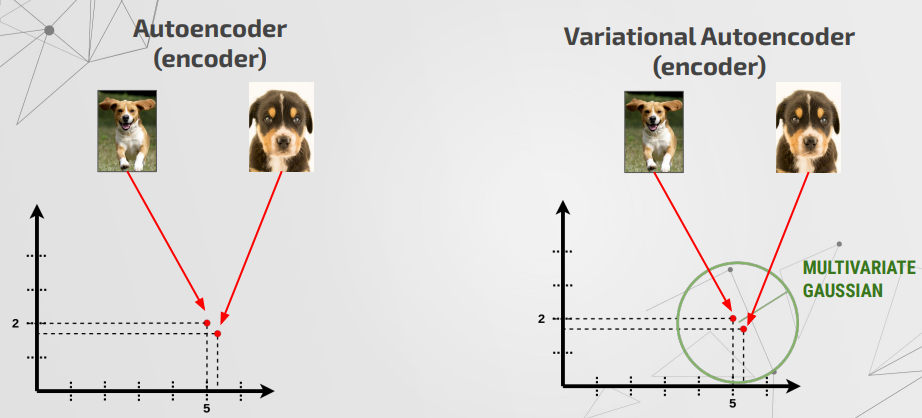

#### Loss function

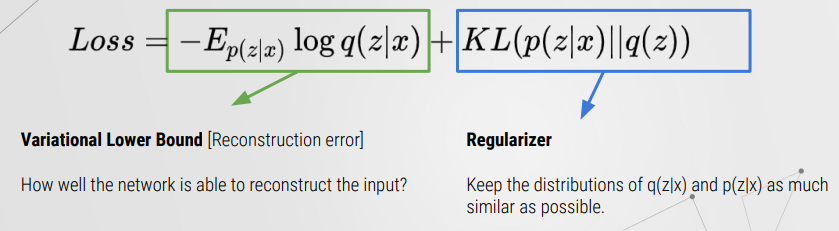

### Imports

In [ ]:
from torch_geometric.nn import GAE
from torch_geometric.nn import VGAE
from torch.utils.tensorboard import SummaryWriter
import torch
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges

### Load the CiteSeer data

In [ ]:
dataset = Planetoid("\..", "CiteSeer", transform=T.NormalizeFeatures())
dataset.data

Processing...
Done!


Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [ ]:
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = None
data

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327])

In [ ]:
data = train_test_split_edges(data)
data

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:13: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Data(x=[3327, 3703], y=[3327], val_pos_edge_index=[2, 227], test_pos_edge_index=[2, 455], train_pos_edge_index=[2, 7740], train_neg_adj_mask=[3327, 3327], val_neg_edge_index=[2, 227], test_neg_edge_index=[2, 455])

### Define the Encoder

In [ ]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv2 = GCNConv(2 * out_channels, out_channels, cached=True) # cached only for transductive learning

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

### Define the Autoencoder

In [ ]:
# parameters
out_channels = 2
num_features = dataset.num_features
epochs = 100

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:
for epoch in range(1, epochs + 1):
    loss = train()

    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


Epoch: 001, AUC: 0.5889, AP: 0.6320
Epoch: 002, AUC: 0.6264, AP: 0.6660
Epoch: 003, AUC: 0.6417, AP: 0.6748
Epoch: 004, AUC: 0.6498, AP: 0.6811
Epoch: 005, AUC: 0.6538, AP: 0.6851
Epoch: 006, AUC: 0.6561, AP: 0.6880
Epoch: 007, AUC: 0.6575, AP: 0.6905
Epoch: 008, AUC: 0.6592, AP: 0.6936
Epoch: 009, AUC: 0.6605, AP: 0.6962
Epoch: 010, AUC: 0.6620, AP: 0.6985
Epoch: 011, AUC: 0.6625, AP: 0.6999
Epoch: 012, AUC: 0.6625, AP: 0.7015
Epoch: 013, AUC: 0.6631, AP: 0.7039
Epoch: 014, AUC: 0.6631, AP: 0.7057
Epoch: 015, AUC: 0.6627, AP: 0.7078
Epoch: 016, AUC: 0.6623, AP: 0.7102
Epoch: 017, AUC: 0.6614, AP: 0.7122
Epoch: 018, AUC: 0.6603, AP: 0.7141
Epoch: 019, AUC: 0.6588, AP: 0.7155
Epoch: 020, AUC: 0.6581, AP: 0.7170
Epoch: 021, AUC: 0.6571, AP: 0.7179
Epoch: 022, AUC: 0.6566, AP: 0.7186
Epoch: 023, AUC: 0.6564, AP: 0.7193
Epoch: 024, AUC: 0.6563, AP: 0.7197
Epoch: 025, AUC: 0.6561, AP: 0.7199
Epoch: 026, AUC: 0.6561, AP: 0.7205
Epoch: 027, AUC: 0.6565, AP: 0.7213
Epoch: 028, AUC: 0.6569, AP:

In [ ]:
Z = model.encode(x, train_pos_edge_index)
Z

tensor([[-0.3132,  0.2351],
        [ 0.9216, -0.6546],
        [-0.8335,  0.5395],
        ...,
        [ 0.3987, -0.2366],
        [-0.8049,  0.5315],
        [-0.8706,  0.5499]], grad_fn=<AddBackward0>)

### Result analysis with Tensorboard

In [ ]:
# parameters
out_channels = 2
num_features = dataset.num_features
epochs = 100

# model
model = GAE(GCNEncoder(num_features, out_channels))

# move to GPU (if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)

# inizialize the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
writer = SummaryWriter('runs/GAE1_experiment_'+'2d_100_epochs')

In [ ]:
for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    
    
    writer.add_scalar('auc train',auc,epoch) # new line
    writer.add_scalar('ap train',ap,epoch)   # new line

Epoch: 001, AUC: 0.6426, AP: 0.6697
Epoch: 002, AUC: 0.6548, AP: 0.6807
Epoch: 003, AUC: 0.6596, AP: 0.6862
Epoch: 004, AUC: 0.6626, AP: 0.6898
Epoch: 005, AUC: 0.6637, AP: 0.6915
Epoch: 006, AUC: 0.6644, AP: 0.6931
Epoch: 007, AUC: 0.6649, AP: 0.6941
Epoch: 008, AUC: 0.6658, AP: 0.6959
Epoch: 009, AUC: 0.6670, AP: 0.6983
Epoch: 010, AUC: 0.6678, AP: 0.7000
Epoch: 011, AUC: 0.6683, AP: 0.7019
Epoch: 012, AUC: 0.6686, AP: 0.7043
Epoch: 013, AUC: 0.6690, AP: 0.7067
Epoch: 014, AUC: 0.6684, AP: 0.7093
Epoch: 015, AUC: 0.6670, AP: 0.7116
Epoch: 016, AUC: 0.6658, AP: 0.7139
Epoch: 017, AUC: 0.6643, AP: 0.7158
Epoch: 018, AUC: 0.6627, AP: 0.7172
Epoch: 019, AUC: 0.6616, AP: 0.7190
Epoch: 020, AUC: 0.6609, AP: 0.7202
Epoch: 021, AUC: 0.6600, AP: 0.7210
Epoch: 022, AUC: 0.6596, AP: 0.7214
Epoch: 023, AUC: 0.6592, AP: 0.7219
Epoch: 024, AUC: 0.6590, AP: 0.7224
Epoch: 025, AUC: 0.6587, AP: 0.7224
Epoch: 026, AUC: 0.6585, AP: 0.7226
Epoch: 027, AUC: 0.6583, AP: 0.7231
Epoch: 028, AUC: 0.6586, AP:

### Graph Variational AutoEncoder (GVAE)

In [ ]:
dataset = Planetoid("\..", "CiteSeer", transform=T.NormalizeFeatures())
data = dataset[0]
data.train_mask = data.val_mask = data.test_mask = data.y = None
data = train_test_split_edges(data)


class VariationalGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VariationalGCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) # cached only for transductive learning
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [ ]:
out_channels = 2
num_features = dataset.num_features
epochs = 300


model = VGAE(VariationalGCNEncoder(num_features, out_channels))  # new line

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
x = data.x.to(device)
train_pos_edge_index = data.train_pos_edge_index.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    
    loss = loss + (1 / data.num_nodes) * model.kl_loss()  # new line
    loss.backward()
    optimizer.step()
    return float(loss)


def test(pos_edge_index, neg_edge_index):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [ ]:
writer = SummaryWriter('runs/VGAE_experiment_'+'2d_100_epochs')

for epoch in range(1, epochs + 1):
    loss = train()
    auc, ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
    print('Epoch: {:03d}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, auc, ap))
    
    
    writer.add_scalar('auc train',auc,epoch) # new line
    writer.add_scalar('ap train',ap,epoch)   # new line

Epoch: 001, AUC: 0.6195, AP: 0.6480
Epoch: 002, AUC: 0.6414, AP: 0.6620
Epoch: 003, AUC: 0.6463, AP: 0.6624
Epoch: 004, AUC: 0.6475, AP: 0.6613
Epoch: 005, AUC: 0.6452, AP: 0.6579
Epoch: 006, AUC: 0.6427, AP: 0.6554
Epoch: 007, AUC: 0.6428, AP: 0.6551
Epoch: 008, AUC: 0.6421, AP: 0.6545
Epoch: 009, AUC: 0.6432, AP: 0.6552
Epoch: 010, AUC: 0.6432, AP: 0.6552
Epoch: 011, AUC: 0.6441, AP: 0.6559
Epoch: 012, AUC: 0.6459, AP: 0.6570
Epoch: 013, AUC: 0.6483, AP: 0.6596
Epoch: 014, AUC: 0.6504, AP: 0.6618
Epoch: 015, AUC: 0.6513, AP: 0.6625
Epoch: 016, AUC: 0.6516, AP: 0.6628
Epoch: 017, AUC: 0.6521, AP: 0.6631
Epoch: 018, AUC: 0.6527, AP: 0.6638
Epoch: 019, AUC: 0.6530, AP: 0.6642
Epoch: 020, AUC: 0.6539, AP: 0.6651
Epoch: 021, AUC: 0.6542, AP: 0.6655
Epoch: 022, AUC: 0.6549, AP: 0.6661
Epoch: 023, AUC: 0.6554, AP: 0.6665
Epoch: 024, AUC: 0.6558, AP: 0.6667
Epoch: 025, AUC: 0.6564, AP: 0.6670
Epoch: 026, AUC: 0.6573, AP: 0.6681
Epoch: 027, AUC: 0.6580, AP: 0.6686
Epoch: 028, AUC: 0.6587, AP:

---

In [ ]:
!pip install -q watermark
%reload_ext watermark
%watermark -a "Sparsh A." -m -iv -u -t -d

Author: Sparsh A.

Last updated: 2021-12-05 18:58:56

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.104+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit

IPython        : 5.5.0
torch_geometric: 2.0.2
torch          : 1.10.0+cu111



---

**END**